Imports

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

Import the images dataset

In [ ]:
import requests, zipfile, io

req = requests.get( 'https://github.com/bartomolina/dscapstone/blob/master/data/dataset-resized.zip?raw=true' ) 
zf = zipfile.ZipFile(io.BytesIO(req.content))
zf.extractall()

Verify extracted files

In [5]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'plastic', 'cardboard', 'trash', 'paper', 'glass', 'metal']

Organize data

In [ ]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [8]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [10]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [11]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


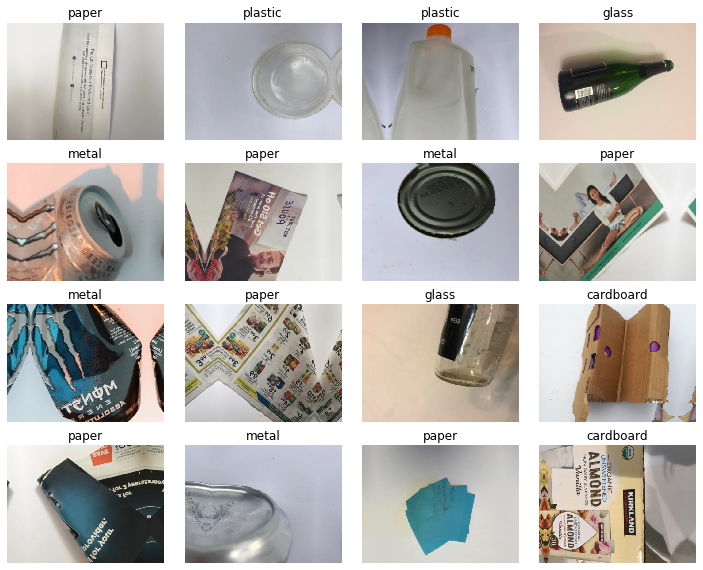

In [12]:
data.show_batch(rows=4,figsize=(10,8))

Model training

In [13]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.82E-05
Min loss divided by 10: 4.90E-03


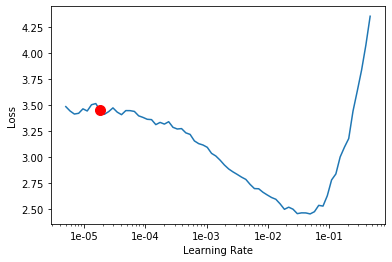

In [15]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

suggestion: 1.15E-02

In [16]:
learn.fit_one_cycle(20,max_lr=1.82e-05)

epoch,train_loss,valid_loss,error_rate,time
0,3.137750,2.429393,0.858730,00:37
1,3.196366,2.363133,0.847619,00:37
2,3.053228,2.193065,0.811111,00:37
3,2.795934,1.950988,0.733333,00:37
4,2.538892,1.721486,0.657143,00:37
5,2.336881,1.527771,0.598413,00:38
6,2.116909,1.383152,0.538095,00:38
7,1.899623,1.226952,0.482540,00:40
8,1.782923,1.167332,0.446032,00:39
9,1.724543,1.121321,0.430159,00:38


In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

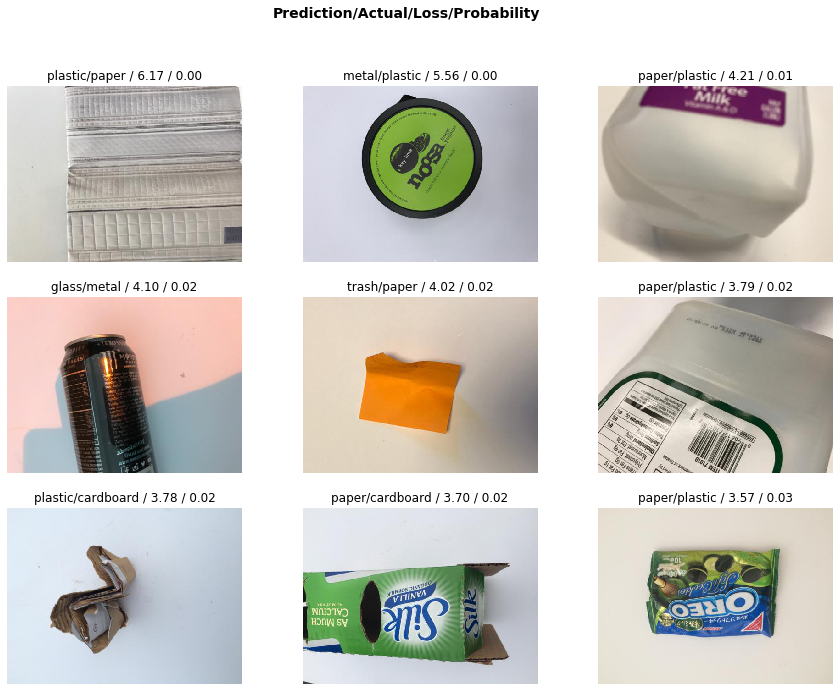

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

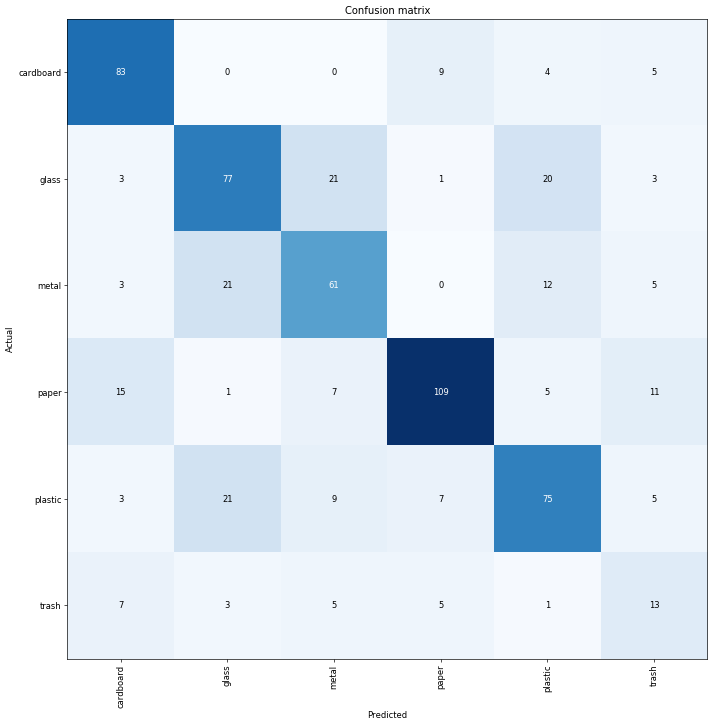

In [19]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('glass', 'metal', 21),
 ('metal', 'glass', 21),
 ('plastic', 'glass', 21),
 ('glass', 'plastic', 20),
 ('paper', 'cardboard', 15),
 ('metal', 'plastic', 12),
 ('paper', 'trash', 11),
 ('cardboard', 'paper', 9),
 ('plastic', 'metal', 9),
 ('paper', 'metal', 7),
 ('plastic', 'paper', 7),
 ('trash', 'cardboard', 7),
 ('cardboard', 'trash', 5),
 ('metal', 'trash', 5),
 ('paper', 'plastic', 5),
 ('plastic', 'trash', 5),
 ('trash', 'metal', 5),
 ('trash', 'paper', 5),
 ('cardboard', 'plastic', 4),
 ('glass', 'cardboard', 3),
 ('glass', 'trash', 3),
 ('metal', 'cardboard', 3),
 ('plastic', 'cardboard', 3),
 ('trash', 'glass', 3)]

In [21]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [22]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[2.6263e-01, 2.7549e-02, 1.2550e-02, 1.0051e-01, 3.4202e-01, 2.5474e-01],
        [5.1995e-04, 7.8274e-01, 6.6481e-02, 1.3541e-03, 1.4475e-01, 4.1586e-03],
        [3.6144e-02, 1.5980e-02, 2.3082e-02, 8.0958e-01, 7.3605e-03, 1.0786e-01],
        ...,
        [1.6156e-02, 5.4494e-01, 1.9198e-01, 2.3811e-03, 2.2240e-01, 2.2145e-02],
        [4.5082e-01, 6.1665e-02, 2.7114e-02, 3.0850e-02, 1.1049e-01, 3.1906e-01],
        [1.9800e-02, 1.8500e-03, 6.4132e-01, 5.3196e-03, 2.3759e-01, 9.4122e-02]])

In [23]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [26]:
yhat

['plastic',
 'glass',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'metal',
 'paper',
 'paper',
 'paper',
 'paper',
 'plastic',
 'glass',
 'glass',
 'metal',
 'metal',
 'paper',
 'trash',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'cardboard',
 'glass',
 'glass',
 'paper',
 'cardboard',
 'plastic',
 'glass',
 'glass',
 'plastic',
 'trash',
 'paper',
 'metal',
 'metal',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'paper',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'paper',
 'plastic',
 'paper',
 'glass',
 'metal',
 'cardboard',
 'metal',
 'paper',
 'metal',
 'cardboard',
 'metal',
 'plastic',
 'glass',
 'glass',
 'trash',
 'metal',
 'metal',
 'plastic',
 'metal',
 'glass',
 'trash',
 'glass',
 'glass',
 'trash',
 'plastic',
 'metal',
 'glass',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'plastic',
 'plastic',
 'trash',
 'cardboard',
 'trash',
 'metal',
 'glass',
 '

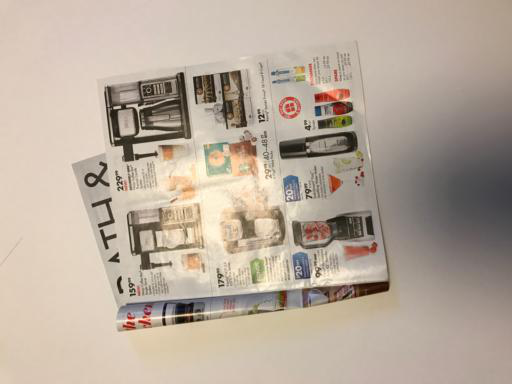

In [37]:
learn.data.test_ds[9][0]

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [39]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['plastic', 'glass', 'paper', 'cardboard', 'plastic']
['cardboard', 'glass', 'paper', 'cardboard', 'plastic']


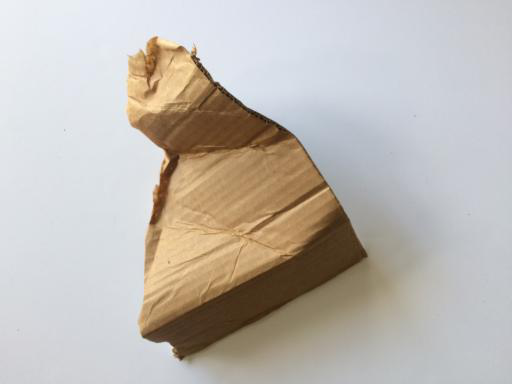

In [40]:
learn.data.test_ds[0][0]

In [41]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 82   1   2   8   4   4]
 [  5  86  18   1  14   2]
 [  3  21  53   7  15   4]
 [  3   7   8 117   3  11]
 [  1  24  12   4  76   4]
 [  5   6   3   5   3  13]]


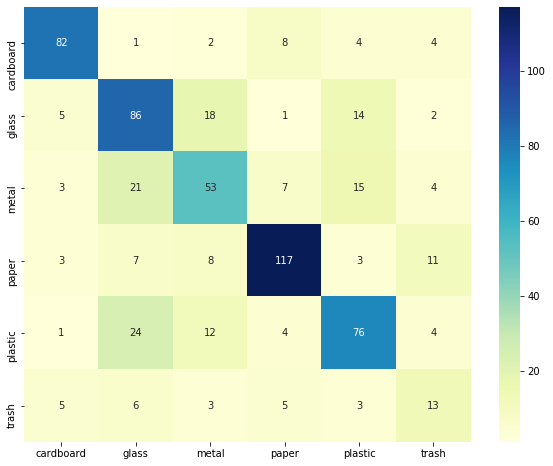

In [42]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [44]:
accuracy = correct/sum(sum(cm))
accuracy

0.6724409448818898